In [112]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import tqdm

import DiffGrad

In [136]:
layer_size = 8
lr = 0.005

def construct_net(layer_size):
    net = nn.Sequential(
        nn.Linear(1, layer_size), nn.Sigmoid(),
        nn.Linear(layer_size, layer_size), nn.Sigmoid(),
        nn.Linear(layer_size, 1)
    )
    
    return net


net_adam = construct_net(layer_size)
net_adagrad = construct_net(layer_size)
net_adadelta = construct_net(layer_size)
net_diffgrad = construct_net(layer_size)

opt_adam = lambda net: optim.Adam(net.parameters(), lr=lr)
opt_adagrad = lambda net: optim.Adagrad(net.parameters(), lr=lr)
opt_adadelta = lambda net: optim.Adadelta(net.parameters(), lr=lr)
opt_sgd = lambda net: optim.SGD(net.parameters(), lr=lr)
opt_diffgrad = lambda net: DiffGrad.DiffGrad(net.parameters(), lr=lr)

In [137]:
num = 100
epochs = 4000
restarts = 25
errors = dict()

In [138]:
x = torch.linspace(-1, 1, num)[:, None]
y = torch.sin(x) * (x ** 4) + torch.cos(x) * torch.sqrt(torch.abs(x)) - torch.exp(x)

In [139]:
mae = lambda x: torch.mean(torch.abs(x))
mse = lambda x: torch.mean(x ** 2)

In [140]:
for net, opt, name in [
    (construct_net, opt_adam, 'Adam optimizer'),
    (construct_net, opt_adagrad, 'Adagrad optimizer'),
    (construct_net, opt_adadelta, 'Adadelta optimizer'),
    (construct_net, opt_diffgrad, 'DiffGrad optimizer'),
    (construct_net, opt_sgd, 'SGD optimizer')
]:
    
    restart_errors = []
    for _ in tqdm.tqdm(range(restarts)):
        _errors = []
        
        _net = construct_net(layer_size)
        _opt = opt(_net)
        
        for epoch in range(epochs):
            _opt.zero_grad()

            yp = _net(x)
            loss = mse(yp - y)
            
#             print(loss)
            
            loss.backward()
            _opt.step()

            _errors += [loss.item()]
        restart_errors += [_errors]
        
    errors[name] = np.array(restart_errors)

100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


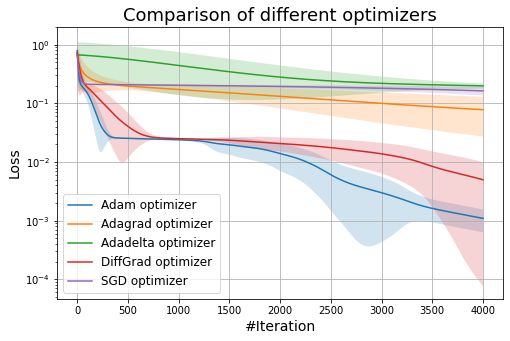

In [146]:
plt.figure(figsize=(8, 5))

plt.title('Comparison of different optimizers', fontsize=18)

for name, values in errors.items():
    iteration = list(range(1, epochs + 1))
    mean = np.mean(values, axis=0)
    std  = np.std(values, axis=0)
    plt.semilogy(iteration, mean, label=name)
    plt.fill_between(iteration, mean - std, mean + std, alpha=0.2)

plt.xlabel('#Iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.show()